In [62]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

# LOAD DATA

In [64]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [65]:
data = sampled_perturbed[0 : 1000]

In [66]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 5
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [67]:


def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :], acc_rate = sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key)
    
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights, key




def run_mcmc(data, k,  key , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

# Full Conditionals and Utilities

In [116]:
def sample_uniq_vals_fullcond_Wasserstein(clusdata, lam, uniq_vals, h, key):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """
    var_prop = 0.01 #variance for the covariance matrix sampling
    cov_prop = np.eye(d) #covariance to sample the mean 
    
    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using truncated normal
    mu,cov = sample_proposal(mu_old,cov_old,var_prop,cov_prop )

    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old)
    print("beta")
    print(beta)
    accept_rate = np.minimum(1, beta)
    draw = tfd.Bernoulli(probs = accept_rate).sample()

    
    # Select the new or old values without an if to help JAX implementation
    if(draw == 0):
        mu = mu_old
        cov = cov_old
    
    #print(mu)
    #print(cov)
    #print(np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NIW(mu_n, lam_n, phi_n, nu_n):
    """
    Sample from a NIW given its parameters
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=nu_n, scale_tril=chol).sample()
    cov = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(mu_n, cov/(lam_n)).sample()
    return mu, cov

def evaluate_NIW(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).prob(x_mu)
    return f1 * f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def sample_proposal(mu_old,cov_old,var_prop,cov_prop):
    
    sigma_0 = cov_old[0,0]
    sigma_1 = cov_old[1,1]
    sigma_symm = cov_old[0,1]
    
    mu = tfd.MultivariateNormalFullCovariance(mu_old , cov_prop).sample()
    
    p0 = (sigma_symm ** 2)/sigma_1
    sigma_0_new = tfd.TruncatedNormal(loc = sigma_0, scale = var_prop, low = p0,high = 1e6).sample()
    
    p0_1 = np.sqrt(sigma_0_new * sigma_1)
    sigma_symm_new = tfd.TruncatedNormal(loc = sigma_symm, scale = var_prop, low = -p0_1, high = p0_1).sample()
    
    p1 = (sigma_symm_new ** 2)/sigma_0_new
    sigma_1_new = tfd.TruncatedNormal(loc = sigma_1, scale = var_prop, low = p1,high = 1e6).sample()
    
    cov = np.array([[sigma_0_new , sigma_symm_new],[sigma_symm_new , sigma_1_new]])
    
    return mu,cov
    

def compute_beta(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old):
    """
    Compute the beta term in the MH algorithm
    """
    # Following https://en.wikipedia.org/wiki/Normal-Wishart_distribution notation, 
    # we choose as proposal a NIW with mu_0 the old mean, W the old cov/nu ,
    # lambda and nu to be tuned for the acceptance ratio
    
    # Target distribution terms
    num_1 = evaluate_NIW(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    # Wasserstein Distances
    prod = 1
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            prod = prod * compute_Wasserstein(mu , cov , mu_k , cov_k) / compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)


    
    print("num_1" + str(num_1))
    print("prod" + str(prod))
    print("den_1" + str(den_1))
    
    if num_1 < 1e-15 and den_1 < 1e-15:
        num_1 = 1
        den_1 = 1
    elif den_1 < 1e-15:
        return 0
  

    return num_1*prod/den_1


def update_cluster_allocs(data, weights, uniq_vals):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    for i in range(len(probs)):
        if np.sum(probs[i]) != 1:
            probs[i] = np.zeros(k)
            idx = np.random.randint(0,k)
            probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    



In [117]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k ,rng_key, niter = 500,nburn = 100)
end = time.time()
print("Total time: " + str(end-start))

#Around 1 minutes instead of 15, 15x speedup :) 

num_10.0
prod0.18851506405320836
den_10.0
beta
0.18851506405320836
num_10.0
prod2.731555672738729
den_10.0
beta
2.731555672738729
num_10.0
prod10.145225823143047
den_10.0
beta
10.145225823143047
num_10.0
prod0.8331615532418281
den_10.0
beta
0.8331615532418281
num_10.0
prod14.510996088381917
den_10.0
beta
14.510996088381917
Iter 1 / 500 Remaining minutes: 0.5 num_10.0
prod0.013136467110536945
den_10.0
beta
0.013136467110536945
num_10.0
prod0.53755314746153
den_10.0
beta
0.53755314746153
num_10.0
prod0.23587704681538574
den_10.0
beta
0.23587704681538574
num_10.0
prod0.0031397893740123194
den_10.0
beta
0.0031397893740123194
num_10.0
prod2.701124632192604
den_10.0
beta
2.701124632192604
num_10.0
prod0.06494942326766
den_10.0
beta
0.06494942326766
num_10.0
prod0.2088937986374832
den_10.0
beta
0.2088937986374832
num_10.0
prod0.3303987595409702
den_10.0
beta
0.3303987595409702
num_10.0
prod0.033352529562332964
den_10.0
beta
0.033352529562332964
num_10.0
prod12.420998003038973
den_10.0
beta
12

num_10.0
prod1.3004770972581765
den_10.0
beta
1.3004770972581765
num_10.0
prod0.668303386069882
den_10.0
beta
0.668303386069882
num_10.0
prod0.2897622006557104
den_10.0
beta
0.2897622006557104
num_10.0
prod0.37756324286259213
den_10.0
beta
0.37756324286259213
num_10.0
prod0.052129977196732735
den_10.0
beta
0.052129977196732735
num_10.0
prod0.4126045563763919
den_10.0
beta
0.4126045563763919
num_10.0
prod0.5116702249511554
den_10.0
beta
0.5116702249511554
num_10.0
prod0.15710954491988655
den_10.0
beta
0.15710954491988655
num_10.0
prod0.21625925956330025
den_10.0
beta
0.21625925956330025
num_10.0
prod0.14403197957842676
den_10.0
beta
0.14403197957842676
num_10.0
prod0.644361091034567
den_10.0
beta
0.644361091034567
num_10.0
prod0.26966659360311135
den_10.0
beta
0.26966659360311135
num_10.0
prod0.1928970912076231
den_10.0
beta
0.1928970912076231
num_10.0
prod0.6712056698794768
den_10.0
beta
0.6712056698794768
num_10.0
prod0.06894562509685306
den_10.0
beta
0.06894562509685306
num_10.0
prod

num_10.0
prod0.10228931357785948
den_10.0
beta
0.10228931357785948
num_10.0
prod0.33379179397303377
den_10.0
beta
0.33379179397303377
num_10.0
prod0.40429731175651973
den_10.0
beta
0.40429731175651973
num_10.0
prod0.04051188539783429
den_10.0
beta
0.04051188539783429
num_10.0
prod0.5699420181404103
den_10.0
beta
0.5699420181404103
num_10.0
prod0.11430229068450058
den_10.0
beta
0.11430229068450058
num_10.0
prod0.39900572613474716
den_10.0
beta
0.39900572613474716
Iter 51 / 500 Remaining minutes: 4.5 num_10.0
prod0.38115852180753806
den_10.0
beta
0.38115852180753806
num_10.0
prod0.09330789350062879
den_10.0
beta
0.09330789350062879
num_10.0
prod0.08257506130448733
den_10.0
beta
0.08257506130448733
num_10.0
prod0.04166620410840256
den_10.0
beta
0.04166620410840256
num_10.0
prod1.244530463264866
den_10.0
beta
1.244530463264866
num_10.0
prod0.394012879166721
den_10.0
beta
0.394012879166721
num_10.0
prod0.11364356291392476
den_10.0
beta
0.11364356291392476
num_10.0
prod0.71723039237787
den_1

num_10.0
prod1.5745572722616712
den_10.0
beta
1.5745572722616712
num_10.0
prod0.41374280987205536
den_10.0
beta
0.41374280987205536
num_10.0
prod0.06538424066275075
den_10.0
beta
0.06538424066275075
num_10.0
prod0.1711827787930883
den_10.0
beta
0.1711827787930883
num_10.0
prod0.0798796656046375
den_10.0
beta
0.0798796656046375
num_10.0
prod0.283607706558425
den_10.0
beta
0.283607706558425
num_10.0
prod0.11930678655997921
den_10.0
beta
0.11930678655997921
num_10.0
prod0.07015144401845536
den_10.0
beta
0.07015144401845536
num_10.0
prod0.15368573361973537
den_10.0
beta
0.15368573361973537
num_10.0
prod0.047245012782820645
den_10.0
beta
0.047245012782820645
num_10.0
prod0.28825603265004346
den_10.0
beta
0.28825603265004346
num_10.0
prod0.12156288295005875
den_10.0
beta
0.12156288295005875
num_10.0
prod0.08020381358278024
den_10.0
beta
0.08020381358278024
num_10.0
prod0.25427997927077206
den_10.0
beta
0.25427997927077206
num_10.0
prod0.05993020823361811
den_10.0
beta
0.05993020823361811
num

num_10.0
prod2.816361916097331
den_10.0
beta
2.816361916097331
num_10.0
prod0.08029488745741546
den_10.0
beta
0.08029488745741546
num_10.0
prod0.03822146054859096
den_10.0
beta
0.03822146054859096
num_10.0
prod0.23875753794699858
den_10.0
beta
0.23875753794699858
num_10.0
prod0.6305232189461074
den_10.0
beta
0.6305232189461074
num_10.0
prod1.2411172779194055
den_10.0
beta
1.2411172779194055
num_10.0
prod0.07859677705180494
den_10.0
beta
0.07859677705180494
num_10.0
prod0.1450606657636425
den_10.0
beta
0.1450606657636425
num_10.0
prod0.5389367650022482
den_10.0
beta
0.5389367650022482
num_10.0
prod0.7628560405373542
den_10.0
beta
0.7628560405373542
num_10.0
prod3.6529630646248465
den_10.0
beta
3.6529630646248465
num_10.0
prod0.23011865950756005
den_10.0
beta
0.23011865950756005
num_10.0
prod0.05937393427309783
den_10.0
beta
0.05937393427309783
num_10.0
prod0.18970307925899824
den_10.0
beta
0.18970307925899824
num_10.0
prod0.42992327765928523
den_10.0
beta
0.42992327765928523
Iter 101 / 

num_10.0
prod0.24343654382561683
den_10.0
beta
0.24343654382561683
num_10.0
prod0.6459358913390438
den_10.0
beta
0.6459358913390438
num_10.0
prod0.28862068042684325
den_10.0
beta
0.28862068042684325
num_10.0
prod0.08223012670037487
den_10.0
beta
0.08223012670037487
num_10.0
prod0.2625000139150427
den_10.0
beta
0.2625000139150427
num_10.0
prod1.3626605441459496
den_10.0
beta
1.3626605441459496
num_10.0
prod0.5117755229039397
den_10.0
beta
0.5117755229039397
num_10.0
prod0.13395391874858792
den_10.0
beta
0.13395391874858792
num_10.0
prod0.04545430009338527
den_10.0
beta
0.04545430009338527
num_10.0
prod0.10049519233328742
den_10.0
beta
0.10049519233328742
num_10.0
prod0.8612172211881063
den_10.0
beta
0.8612172211881063
num_10.0
prod0.5662836398729517
den_10.0
beta
0.5662836398729517
num_10.0
prod0.1575216602791866
den_10.0
beta
0.1575216602791866
num_10.0
prod0.09825019218419065
den_10.0
beta
0.09825019218419065
num_10.0
prod0.17811708243749558
den_10.0
beta
0.17811708243749558
num_10.0


num_10.0
prod1.1256509332079798
den_10.0
beta
1.1256509332079798
num_10.0
prod0.48922479067480773
den_10.0
beta
0.48922479067480773
num_10.0
prod0.2045007941610902
den_10.0
beta
0.2045007941610902
num_10.0
prod0.10822670791952432
den_10.0
beta
0.10822670791952432
num_10.0
prod0.1915903935830699
den_10.0
beta
0.1915903935830699
num_10.0
prod0.8241500180294435
den_10.0
beta
0.8241500180294435
num_10.0
prod0.42524365981377793
den_10.0
beta
0.42524365981377793
num_10.0
prod0.11539203942534536
den_10.0
beta
0.11539203942534536
num_10.0
prod0.060652568896901134
den_10.0
beta
0.060652568896901134
num_10.0
prod0.0955503180593889
den_10.0
beta
0.0955503180593889
num_10.0
prod0.540349172974153
den_10.0
beta
0.540349172974153
num_10.0
prod0.5768404889427043
den_10.0
beta
0.5768404889427043
num_10.0
prod0.14790354176535012
den_10.0
beta
0.14790354176535012
num_10.0
prod0.06653048864552773
den_10.0
beta
0.06653048864552773
num_10.0
prod0.13853052757144235
den_10.0
beta
0.13853052757144235
num_10.0


num_10.0
prod0.1584927734985384
den_10.0
beta
0.1584927734985384
num_10.0
prod0.8310135257679251
den_10.0
beta
0.8310135257679251
num_10.0
prod0.13926471742065405
den_10.0
beta
0.13926471742065405
num_10.0
prod0.1684308004611575
den_10.0
beta
0.1684308004611575
num_10.0
prod0.19127480658255133
den_10.0
beta
0.19127480658255133
num_10.0
prod0.605808476830866
den_10.0
beta
0.605808476830866
num_10.0
prod1.2017356160074608
den_10.0
beta
1.2017356160074608
num_10.0
prod0.39932789389963175
den_10.0
beta
0.39932789389963175
num_10.0
prod0.2729258454020224
den_10.0
beta
0.2729258454020224
num_10.0
prod0.15322346410136475
den_10.0
beta
0.15322346410136475
num_10.0
prod0.5236889707678758
den_10.0
beta
0.5236889707678758
num_10.0
prod0.9109317235136589
den_10.0
beta
0.9109317235136589
num_10.0
prod0.26794518023382674
den_10.0
beta
0.26794518023382674
num_10.0
prod0.13942244521609104
den_10.0
beta
0.13942244521609104
num_10.0
prod0.04057728235512643
den_10.0
beta
0.04057728235512643
num_10.0
prod

num_10.0
prod0.3262617651616141
den_10.0
beta
0.3262617651616141
num_10.0
prod0.9155669545915676
den_10.0
beta
0.9155669545915676
num_10.0
prod0.16640567168758796
den_10.0
beta
0.16640567168758796
num_10.0
prod0.12316855003642146
den_10.0
beta
0.12316855003642146
num_10.0
prod0.0734018798059446
den_10.0
beta
0.0734018798059446
num_10.0
prod0.2859246218277285
den_10.0
beta
0.2859246218277285
num_10.0
prod2.100928687276361
den_10.0
beta
2.100928687276361
num_10.0
prod0.3977660331644517
den_10.0
beta
0.3977660331644517
num_10.0
prod0.07363669858809344
den_10.0
beta
0.07363669858809344
num_10.0
prod0.16900297798608785
den_10.0
beta
0.16900297798608785
num_10.0
prod0.24523314821183964
den_10.0
beta
0.24523314821183964
num_10.0
prod0.782256331486264
den_10.0
beta
0.782256331486264
num_10.0
prod0.37112417992030394
den_10.0
beta
0.37112417992030394
num_10.0
prod0.1201624885551453
den_10.0
beta
0.1201624885551453
num_10.0
prod0.12237893115217982
den_10.0
beta
0.12237893115217982
num_10.0
prod0.

num_10.0
prod1.388912495900676
den_10.0
beta
1.388912495900676
num_10.0
prod1.2380340537174928
den_10.0
beta
1.2380340537174928
num_10.0
prod0.06868192357764948
den_10.0
beta
0.06868192357764948
num_10.0
prod0.06941159557436459
den_10.0
beta
0.06941159557436459
num_10.0
prod0.17679381835698033
den_10.0
beta
0.17679381835698033
num_10.0
prod0.5108326389988254
den_10.0
beta
0.5108326389988254
num_10.0
prod0.7635448645702926
den_10.0
beta
0.7635448645702926
num_10.0
prod0.08248543601511435
den_10.0
beta
0.08248543601511435
num_10.0
prod0.22816191860111748
den_10.0
beta
0.22816191860111748
num_10.0
prod0.4952088809868671
den_10.0
beta
0.4952088809868671
num_10.0
prod0.476749231707705
den_10.0
beta
0.476749231707705
num_10.0
prod0.07917500231533621
den_10.0
beta
0.07917500231533621
num_10.0
prod0.11321553291373723
den_10.0
beta
0.11321553291373723
num_10.0
prod0.36639898115238423
den_10.0
beta
0.36639898115238423
num_10.0
prod0.4585456605824395
den_10.0
beta
0.4585456605824395
num_10.0
prod

num_10.0
prod0.06787358329779526
den_10.0
beta
0.06787358329779526
num_10.0
prod0.03294696064363016
den_10.0
beta
0.03294696064363016
num_10.0
prod0.09208537191928456
den_10.0
beta
0.09208537191928456
num_10.0
prod0.275329574602686
den_10.0
beta
0.275329574602686
num_10.0
prod0.3041105913122059
den_10.0
beta
0.3041105913122059
num_10.0
prod0.08306519039961845
den_10.0
beta
0.08306519039961845
num_10.0
prod0.11740552078914852
den_10.0
beta
0.11740552078914852
num_10.0
prod0.06485673521348957
den_10.0
beta
0.06485673521348957
num_10.0
prod0.13061517859714644
den_10.0
beta
0.13061517859714644
num_10.0
prod0.02234296128017228
den_10.0
beta
0.02234296128017228
num_10.0
prod0.4751268862991752
den_10.0
beta
0.4751268862991752
num_10.0
prod0.08462016605112478
den_10.0
beta
0.08462016605112478
num_10.0
prod0.1360023862691557
den_10.0
beta
0.1360023862691557
num_10.0
prod0.18036625937866343
den_10.0
beta
0.18036625937866343
num_10.0
prod0.10506613393077754
den_10.0
beta
0.10506613393077754
num_1

num_10.0
prod0.36417590722359083
den_10.0
beta
0.36417590722359083
num_10.0
prod0.11579140928269467
den_10.0
beta
0.11579140928269467
num_10.0
prod0.19240990377360237
den_10.0
beta
0.19240990377360237
Iter 291 / 500 Remaining minutes: 1.3 num_10.0
prod0.13924973553498443
den_10.0
beta
0.13924973553498443
num_10.0
prod0.2978893203644547
den_10.0
beta
0.2978893203644547
num_10.0
prod0.31445453231174514
den_10.0
beta
0.31445453231174514
num_10.0
prod0.09511001209300671
den_10.0
beta
0.09511001209300671
num_10.0
prod0.5116260286827364
den_10.0
beta
0.5116260286827364
num_10.0
prod0.11698894019941868
den_10.0
beta
0.11698894019941868
num_10.0
prod0.5770088135836811
den_10.0
beta
0.5770088135836811
num_10.0
prod0.11865627332310662
den_10.0
beta
0.11865627332310662
num_10.0
prod0.2830231987496336
den_10.0
beta
0.2830231987496336
num_10.0
prod0.3367509988810928
den_10.0
beta
0.3367509988810928
num_10.0
prod0.07689168758717271
den_10.0
beta
0.07689168758717271
num_10.0
prod0.285218366291902
den

num_10.0
prod0.19076338418596922
den_10.0
beta
0.19076338418596922
Iter 321 / 500 Remaining minutes: 1.5 num_10.0
prod0.4985943861964649
den_10.0
beta
0.4985943861964649
num_10.0
prod0.45181951577874513
den_10.0
beta
0.45181951577874513
num_10.0
prod0.08407362292849978
den_10.0
beta
0.08407362292849978
num_10.0
prod0.09399735292053277
den_10.0
beta
0.09399735292053277
num_10.0
prod0.7655976636572639
den_10.0
beta
0.7655976636572639
num_10.0
prod0.32676603342509153
den_10.0
beta
0.32676603342509153
num_10.0
prod0.4106713094658804
den_10.0
beta
0.4106713094658804
num_10.0
prod0.043003148574330324
den_10.0
beta
0.043003148574330324
num_10.0
prod0.13897640743910236
den_10.0
beta
0.13897640743910236
num_10.0
prod0.32726654668862654
den_10.0
beta
0.32726654668862654
num_10.0
prod0.07980469927159088
den_10.0
beta
0.07980469927159088
num_10.0
prod0.03073174088805506
den_10.0
beta
0.03073174088805506
num_10.0
prod0.12375211614048139
den_10.0
beta
0.12375211614048139
num_10.0
prod0.0893156945846

num_10.0
prod0.3750058565005991
den_10.0
beta
0.3750058565005991
num_10.0
prod1.5007264048266327
den_10.0
beta
1.5007264048266327
num_10.0
prod0.2336706114384923
den_10.0
beta
0.2336706114384923
num_10.0
prod0.061641838912615605
den_10.0
beta
0.061641838912615605
num_10.0
prod0.03838792628141587
den_10.0
beta
0.03838792628141587
num_10.0
prod0.04094364401488373
den_10.0
beta
0.04094364401488373
num_10.0
prod0.08642466182432935
den_10.0
beta
0.08642466182432935
num_10.0
prod0.1390012470912404
den_10.0
beta
0.1390012470912404
num_10.0
prod0.12353718545141297
den_10.0
beta
0.12353718545141297
num_10.0
prod0.05589828407070675
den_10.0
beta
0.05589828407070675
num_10.0
prod0.37871359028058693
den_10.0
beta
0.37871359028058693
num_10.0
prod0.4799967428767572
den_10.0
beta
0.4799967428767572
num_10.0
prod0.04701208505401216
den_10.0
beta
0.04701208505401216
num_10.0
prod0.04234037493506951
den_10.0
beta
0.04234037493506951
num_10.0
prod0.08256670481945612
den_10.0
beta
0.08256670481945612
num

num_10.0
prod0.42089270860760725
den_10.0
beta
0.42089270860760725
num_10.0
prod0.35619875806500817
den_10.0
beta
0.35619875806500817
num_10.0
prod0.08909259002677401
den_10.0
beta
0.08909259002677401
num_11.796003230818707e-74
prod0.12240552978274481
den_12.153748218696292e-84
beta
0.12240552978274481
num_10.0
prod0.15083145946301338
den_10.0
beta
0.15083145946301338
num_10.0
prod0.2999259805409452
den_10.0
beta
0.2999259805409452
num_10.0
prod0.1883188651594782
den_10.0
beta
0.1883188651594782
num_10.0
prod0.13906834488363765
den_10.0
beta
0.13906834488363765
num_10.0
prod0.1465497804395262
den_10.0
beta
0.1465497804395262
num_11.0736571558338356e-126
prod0.29510809135413907
den_12.153748218696292e-84
beta
0.29510809135413907
num_10.0
prod0.04282454088369375
den_10.0
beta
0.04282454088369375
num_10.0
prod0.030244212591227945
den_10.0
beta
0.030244212591227945
num_10.0
prod0.24077308063771702
den_10.0
beta
0.24077308063771702
num_10.0
prod0.16272682226769705
den_10.0
beta
0.1627268222

num_10.0
prod0.09333398962738201
den_10.0
beta
0.09333398962738201
num_10.0
prod0.09226540442715986
den_10.0
beta
0.09226540442715986
num_10.0
prod0.30255005528896645
den_10.0
beta
0.30255005528896645
num_10.0
prod0.023650102211610072
den_10.0
beta
0.023650102211610072
num_10.0
prod0.25039017241658323
den_10.0
beta
0.25039017241658323
num_10.0
prod0.3033967745212926
den_10.0
beta
0.3033967745212926
num_10.0
prod0.0967453483369439
den_10.0
beta
0.0967453483369439
num_10.0
prod0.545790798002985
den_10.0
beta
0.545790798002985
num_10.0
prod0.24582495860965156
den_10.0
beta
0.24582495860965156
num_10.0
prod0.6751374373368496
den_10.0
beta
0.6751374373368496
num_10.0
prod0.20050008433067543
den_10.0
beta
0.20050008433067543
num_10.0
prod0.15232087293123614
den_10.0
beta
0.15232087293123614
num_11.2449275829608e-195
prod0.27215098027605633
den_16.584989885112658e-147
beta
0.27215098027605633
num_10.0
prod0.134747125547166
den_10.0
beta
0.134747125547166
Iter 431 / 500 Remaining minutes: 0.5 

num_10.0
prod0.11291325020892698
den_10.0
beta
0.11291325020892698
num_10.0
prod0.12313070069897458
den_10.0
beta
0.12313070069897458
num_10.0
prod0.008648967720262947
den_10.0
beta
0.008648967720262947
num_10.0
prod0.3068087366384781
den_10.0
beta
0.3068087366384781
num_10.0
prod0.19527811940458195
den_10.0
beta
0.19527811940458195
num_10.0
prod0.15991903944525665
den_10.0
beta
0.15991903944525665
num_10.0
prod0.042279372174153895
den_10.0
beta
0.042279372174153895
num_10.0
prod0.037354540153128245
den_10.0
beta
0.037354540153128245
num_10.0
prod0.3256201690363382
den_10.0
beta
0.3256201690363382
num_10.0
prod0.17280994425587093
den_10.0
beta
0.17280994425587093
num_10.0
prod0.22434009071590552
den_10.0
beta
0.22434009071590552
num_10.0
prod0.056534597261134384
den_10.0
beta
0.056534597261134384
num_10.0
prod0.023233645858843965
den_10.0
beta
0.023233645858843965
num_10.0
prod0.20379467636655138
den_10.0
beta
0.20379467636655138
num_10.0
prod0.22267212487286514
den_10.0
beta
0.2226721

num_10.0
prod0.17421965733273406
den_10.0
beta
0.17421965733273406
num_10.0
prod0.25829448858785964
den_10.0
beta
0.25829448858785964
num_10.0
prod0.11783524660334639
den_10.0
beta
0.11783524660334639
num_10.0
prod0.1950943536874617
den_10.0
beta
0.1950943536874617
num_10.0
prod0.196931099242933
den_10.0
beta
0.196931099242933
num_10.0
prod0.22647425471837881
den_10.0
beta
0.22647425471837881
num_10.0
prod0.1566361667232904
den_10.0
beta
0.1566361667232904
num_10.0
prod0.09280971184306602
den_10.0
beta
0.09280971184306602
num_10.0
prod0.2040432932542238
den_10.0
beta
0.2040432932542238
num_10.0
prod0.06259415271091638
den_10.0
beta
0.06259415271091638
num_10.0
prod0.19450536609656274
den_10.0
beta
0.19450536609656274
Iter 481 / 500 Remaining minutes: 0.2 num_10.0
prod0.1889147752658254
den_10.0
beta
0.1889147752658254
num_10.0
prod0.11229482387451774
den_10.0
beta
0.11229482387451774
num_10.0
prod0.4741494931425502
den_10.0
beta
0.4741494931425502
num_10.0
prod0.13539427236990936
den_1

# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

4    498
2    413
3     76
1      7
0      6
dtype: int64


<BarContainer object of 5 artists>

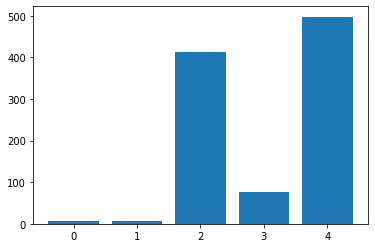

In [118]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


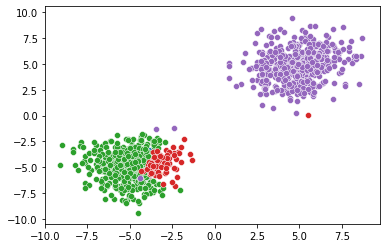

In [119]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

ValueError: The palette list has the wrong number of colors.

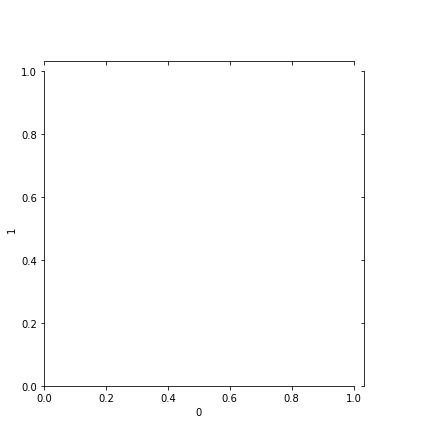

In [120]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [121]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

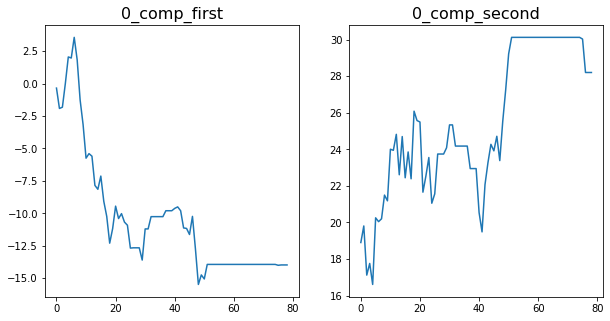

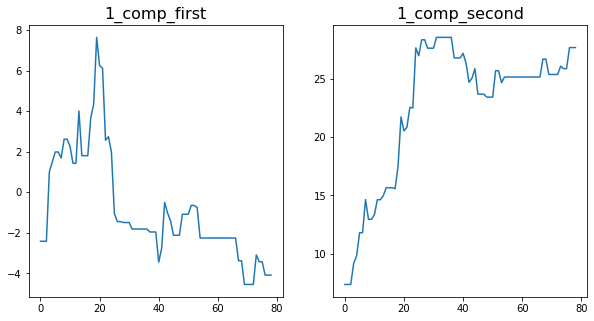

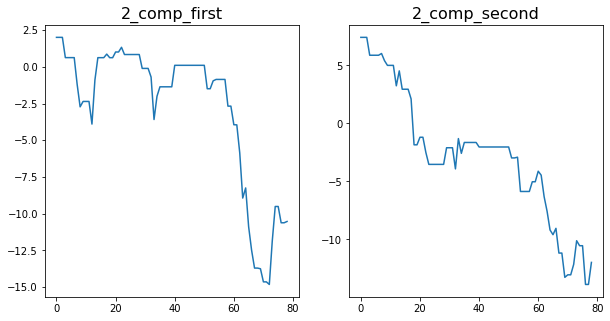

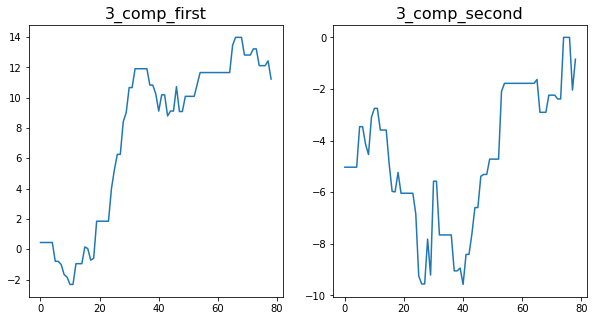

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7feb0edebca8; dead>))>
Traceback (most recent call last):
  File "/Users/leopere/anaconda3/lib/python3.7/site-packages/tensorflow_probability/substrates/numpy/internal/cache_util.py", line 149, in _cleanup
    if self._alive:
AttributeError: _alive


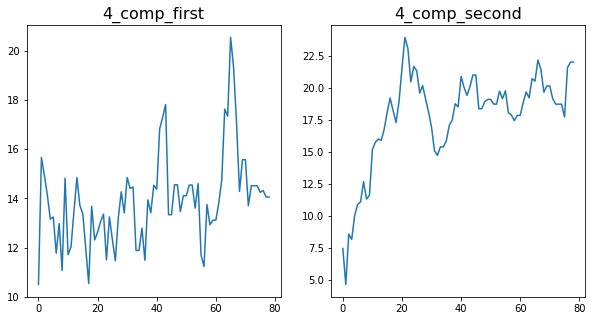

In [122]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

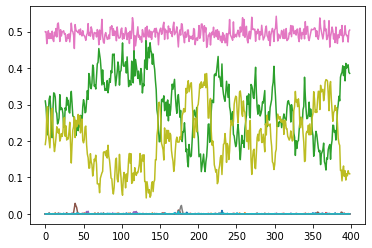

In [17]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [18]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


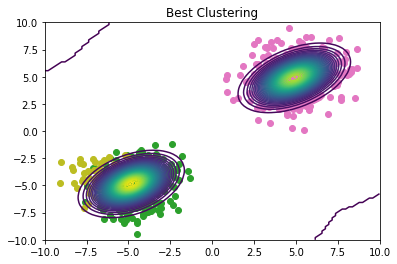

In [19]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)